In [2]:
import pandas as pd
import numpy as np
from numpy.linalg import pinv

In [3]:
def mahalanobis_distance(X_t, X_c):
    X = np.vstack([X_t, X_c])
    cov = np.cov(X, rowvar=False)
    inv_cov = pinv(cov)
    diff = X_t.mean(axis=0) - X_c.mean(axis=0)
    return diff @ inv_cov @ diff

def rerandomize(X, n_treat, threshold=2.0, max_iter=10000, seed=None):
    np.random.seed(seed)
    N = X.shape[0]
    idx = np.arange(N)
    best = (None, None, np.inf)
    for _ in range(max_iter):
        treat_idx = np.random.choice(idx, size=n_treat, replace=False)
        control_idx = np.setdiff1d(idx, treat_idx)
        M = mahalanobis_distance(X[treat_idx], X[control_idx])
        if M < threshold:
            return treat_idx, control_idx, M
        if M < best[2]:
            best = (treat_idx, control_idx, M)
    return best

In [4]:
np.random.seed(42)
N = 200               # sample size
p = 3                 # number of covariates
X = np.random.normal(size=(N, p))  # covariates
true_tau = 2.0        # true ATE

# Outcome model: y = β0 + β'x + τ*W + ε
beta = np.array([1.5, -1.0, 0.5])
epsilon = np.random.normal(0, 1, size=N)
y0 = X @ beta + epsilon
y1 = y0 + true_tau    # additive treatment effect

In [6]:
data = pd.concat(
    [
        pd.DataFrame(X, columns=[f'x{i+1}' for i in range(p)]),
        pd.DataFrame({'y0': y0, 'y1': y1})
    ],
    axis=1
)

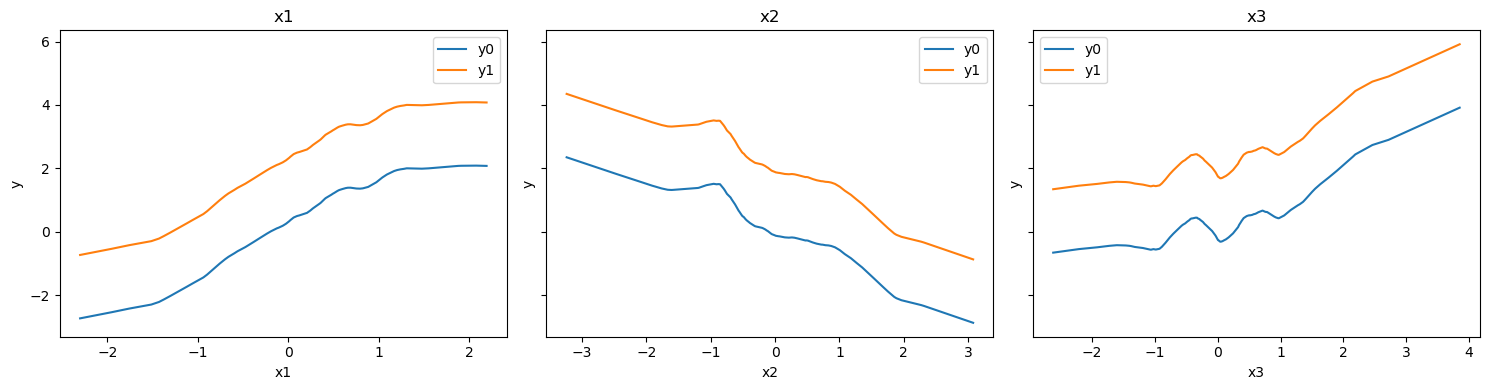

In [10]:
#make a smooth line plot of each covariate (x1, x2, x3) against y0 and y1 in panels
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.nonparametric.smoothers_lowess import lowess

# Pack into arrays
X = [X[:, 0], X[:, 1], X[:, 2]]
names = ['x1', 'x2', 'x3']
Y = [y0, y1]


# Create 3-panel plot
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

for i, ax in enumerate(axes):
    for j, y in enumerate(Y):
        smoothed = lowess(y, X[i], frac=0.3)  # frac controls smoothness
        label = f"y{j}"  # y0 or y1
        ax.plot(smoothed[:, 0], smoothed[:, 1], label=label)
    ax.set_title(names[i])
    ax.set_xlabel(names[i])
    ax.set_ylabel("y")
    ax.legend()

plt.tight_layout()
plt.show()


In [4]:
treat_idx = np.random.choice(N, N//2, replace=False)
control_idx = np.setdiff1d(np.arange(N), treat_idx)
W = np.zeros(N)
W[treat_idx] = 1

y_obs = np.where(W==1, y1, y0)

ATE_rand = y_obs[W==1].mean() - y_obs[W==0].mean()
ATT_rand = (y_obs[W==1] - y0[W==1]).mean()  # we can calculate "true" ATT in sim

print(f"Randomized ATE estimate: {ATE_rand:.3f}")
print(f"Randomized ATT estimate: {ATT_rand:.3f}")

Randomized ATE estimate: 2.179
Randomized ATT estimate: 2.000


In [5]:
t_idx, c_idx, M_val = rerandomize(X, N//2, threshold=1.5, seed=123)
W_re = np.zeros(N)
W_re[t_idx] = 1

y_obs_re = np.where(W_re==1, y1, y0)

ATE_re = y_obs_re[W_re==1].mean() - y_obs_re[W_re==0].mean()
ATT_re = (y_obs_re[W_re==1] - y0[W_re==1]).mean()
print(f"Rerandomization: ATE={ATE_re:.3f}, ATT={ATT_re:.3f}, Mahalanobis={M_val:.3f}")

Rerandomization: ATE=1.450, ATT=2.000, Mahalanobis=0.154


In [ ]:
cov_diff_rand = X[W==1].mean(axis=0) - X[W==0].mean(axis=0)
cov_diff_re = X[W_re==1].mean(axis=0) - X[W_re==0].mean(axis=0)
print("\nCovariate mean differences:")
print(pd.DataFrame({"Randomization": cov_diff_rand, "Rerandomization": cov_diff_re}))


Covariate mean differences:
   Randomization  Rerandomization
0       0.057184        -0.312914
1      -0.033605        -0.137849
2       0.150687        -0.096636
